In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
import math
from scipy.stats import wasserstein_distance
from sklearn.preprocessing import StandardScaler
# from qolmat.diffusion_model  import ImputerDiffusion
# from qolmat.model  import TabDDPM, TsDDPM
from diffusion import DDPM

In [2]:
from load_data import prepare_data, aggregate_market_data
from models import CustomTransformerTimeSeries
from dataloader import TimeSeriesDataset

In [3]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))

## Load Data

In [4]:
from_year = "1999"
end_year = "2019"
start_year_test = "2020"

In [5]:
data = aggregate_market_data()
df_reindexed, df_orig, df = prepare_data(data, from_year = from_year, start_year_test = None)

100%|██████████| 141/141 [00:01<00:00, 70.67it/s]


### Preprocess Data

In [6]:
train_df = df_reindexed#.loc[:'2019']
train_df = train_df.interpolate(method='nearest')
X_train = train_df.to_numpy()
X_train = torch.tensor(X_train, dtype=torch.float32, device=device)

## Hyperparameters

In [7]:
# hyperparameters

# diffusion hyperparameters
timesteps = 96
beta1 = 1e-4
beta2 = 0.02

# network hyperparameters
input_size = 30
hidden_dim = 32
n_feat = df_reindexed.shape[1] 
save_dir = './weights/'

# training hyperparameters
batch_size = 64
n_epoch = 50
lrate=1e-3

## TSGM

### Models

In [8]:
#model = CustomTransformerTimeSeries(input_size=input_size, n_feat=n_feat, hidden_size=32, num_layers=2, num_heads=2, dropout_prob=0.1)

In [13]:
from models import AutoEncoder, ResidualBlockTS
model = AutoEncoder(num_noise_steps=timesteps,
                    dim_input=n_feat,
                    dim_output=n_feat,
                    residual_block=ResidualBlockTS(hidden_dim, input_size, hidden_dim),
                    dim_embedding=hidden_dim,
)

In [14]:
# model_qolmat = TsDDPM(num_noise_steps=50,nheads_feature=8,nheads_time=8)

### Training

In [61]:
seq_len = 30
train_dataset = TimeSeriesDataset(X_train, seq_len=seq_len)
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = False)
optim = torch.optim.Adam(model.parameters(), lr=lrate)

In [62]:
from models import AutoEncoder, ResidualBlockTS, RNNEncDec
dim_model = 64
timesteps = 1000
beta1 = 1e-4
beta2 = 0.02
hidden_dim = 64
n_feat = df_reindexed.shape[1] 
batch_size = 64

score_model = AutoEncoder(num_noise_steps = timesteps,
                    dim_input = 2*dim_model,
                    dim_output = dim_model,
                    residual_block = ResidualBlockTS(hidden_dim,
                                                     seq_len-1,
                                                     hidden_dim),
                    dim_embedding = hidden_dim).to(device)

RNN_model = RNNEncDec(dim_input=n_feat,
                      dim_model=dim_model,
                      num_layers=2,
                      device=device)

from diffusion import TSGM
tsgm = TSGM(score_model=score_model,
            RNN_model=RNN_model,
            num_noise_steps=timesteps,
            beta_0=beta1,
            beta_1=beta2,
            device=device)


In [63]:
# train full model
losses_pre, losses = tsgm.train(train_loader,
                    n_epoch_train=40,
                    n_epoch_pretrain=100,
                    lrate=2e-4,
                    use_alt=True)

Epoch 1/100, Loss: 0.978378127515316
Epoch 2/100, Loss: 0.9632098445296288
Epoch 3/100, Loss: 0.9595497891306877
Epoch 4/100, Loss: 0.9537546834349633
Epoch 5/100, Loss: 0.9498365679383278
Epoch 6/100, Loss: 0.9447893461585045
Epoch 7/100, Loss: 0.935351919233799
Epoch 8/100, Loss: 0.9400585767626762
Epoch 9/100, Loss: 0.9185902526974679
Epoch 10/100, Loss: 0.9131574901938438
Epoch 11/100, Loss: 0.8980574589967728
Epoch 12/100, Loss: 0.8876192733645439
Epoch 13/100, Loss: 0.8918000438809395
Epoch 14/100, Loss: 0.888844123184681
Epoch 15/100, Loss: 0.8750441077351571
Epoch 16/100, Loss: 0.8563463827967643
Epoch 17/100, Loss: 0.8304499852657318
Epoch 18/100, Loss: 0.80307343095541
Epoch 19/100, Loss: 0.7945266082882881
Epoch 20/100, Loss: 0.7692621356248855
Epoch 21/100, Loss: 0.7370860655605793
Epoch 22/100, Loss: 0.7119218491017818
Epoch 23/100, Loss: 0.6987662567198276
Epoch 24/100, Loss: 0.6772732657194137
Epoch 25/100, Loss: 0.6592377535998821
Epoch 26/100, Loss: 0.6184381860494613


100%|██████████| 100/100 [00:25<00:00,  3.89it/s]


Epoch 1/40,	Loss: 60.87616304755211,	Loss_EncDec: 0.10703227370977401


100%|██████████| 100/100 [00:25<00:00,  3.90it/s]


Epoch 2/40,	Loss: 45.116745890975,	Loss_EncDec: 0.10827959567308426


100%|██████████| 100/100 [00:25<00:00,  3.88it/s]


Epoch 3/40,	Loss: 31.976625628173352,	Loss_EncDec: 0.11289937194436789


100%|██████████| 100/100 [00:25<00:00,  3.90it/s]


Epoch 4/40,	Loss: 25.850922330915928,	Loss_EncDec: 0.11250452362000943


100%|██████████| 100/100 [00:26<00:00,  3.80it/s]


Epoch 5/40,	Loss: 22.08825266778469,	Loss_EncDec: 0.10683609317988157


100%|██████████| 100/100 [00:25<00:00,  3.85it/s]


Epoch 6/40,	Loss: 19.087904495894907,	Loss_EncDec: 0.10989576738327742


100%|██████████| 100/100 [00:25<00:00,  3.86it/s]


Epoch 7/40,	Loss: 16.98355937808752,	Loss_EncDec: 0.10849629577249288


100%|██████████| 100/100 [00:25<00:00,  3.88it/s]


Epoch 8/40,	Loss: 15.352021829932928,	Loss_EncDec: 0.10647337306290865


100%|██████████| 100/100 [00:25<00:00,  3.87it/s]


Epoch 9/40,	Loss: 13.493950407654047,	Loss_EncDec: 0.1012838464230299


100%|██████████| 100/100 [00:25<00:00,  3.89it/s]


Epoch 10/40,	Loss: 11.7891489033401,	Loss_EncDec: 0.09627571046352386


100%|██████████| 100/100 [00:25<00:00,  3.85it/s]


Epoch 11/40,	Loss: 10.732396533489228,	Loss_EncDec: 0.0960777198895812


100%|██████████| 100/100 [00:25<00:00,  3.88it/s]


Epoch 12/40,	Loss: 10.521649645268917,	Loss_EncDec: 0.09491410430520773


100%|██████████| 100/100 [00:25<00:00,  3.89it/s]


Epoch 13/40,	Loss: 9.908350930809975,	Loss_EncDec: 0.09272303633391857


100%|██████████| 100/100 [00:25<00:00,  3.88it/s]


Epoch 14/40,	Loss: 9.721577221900224,	Loss_EncDec: 0.09469258122146129


100%|██████████| 100/100 [00:25<00:00,  3.89it/s]


Epoch 15/40,	Loss: 9.598379572182894,	Loss_EncDec: 0.09125486601144076


100%|██████████| 100/100 [00:25<00:00,  3.88it/s]


Epoch 16/40,	Loss: 9.579743447005749,	Loss_EncDec: 0.09380743246525526


100%|██████████| 100/100 [00:25<00:00,  3.89it/s]


Epoch 17/40,	Loss: 9.377811526656151,	Loss_EncDec: 0.09892586626112461


100%|██████████| 100/100 [00:25<00:00,  3.91it/s]


Epoch 18/40,	Loss: 8.645444159656764,	Loss_EncDec: 0.09296050682663917


100%|██████████| 100/100 [00:25<00:00,  3.86it/s]


Epoch 19/40,	Loss: 8.560697843432427,	Loss_EncDec: 0.08978517390787602


100%|██████████| 100/100 [00:25<00:00,  3.91it/s]


Epoch 20/40,	Loss: 8.352636657059193,	Loss_EncDec: 0.09368489891290664


100%|██████████| 100/100 [00:25<00:00,  3.91it/s]


Epoch 21/40,	Loss: 7.742827473431825,	Loss_EncDec: 0.09454200841486454


100%|██████████| 100/100 [00:25<00:00,  3.92it/s]


Epoch 22/40,	Loss: 7.535113267600536,	Loss_EncDec: 0.09403903502970934


100%|██████████| 100/100 [00:25<00:00,  3.90it/s]


Epoch 23/40,	Loss: 7.464501162320375,	Loss_EncDec: 0.087164126932621


100%|██████████| 100/100 [00:25<00:00,  3.88it/s]


Epoch 24/40,	Loss: 7.509481778815388,	Loss_EncDec: 0.08281291222199798


100%|██████████| 100/100 [00:25<00:00,  3.90it/s]


Epoch 25/40,	Loss: 7.367165570408106,	Loss_EncDec: 0.0804931121505797


100%|██████████| 100/100 [00:25<00:00,  3.86it/s]


Epoch 26/40,	Loss: 7.494373338669538,	Loss_EncDec: 0.079563870690763


100%|██████████| 100/100 [00:26<00:00,  3.80it/s]


Epoch 27/40,	Loss: 7.028716557696462,	Loss_EncDec: 0.07585331626236438


100%|██████████| 100/100 [00:26<00:00,  3.81it/s]


Epoch 28/40,	Loss: 6.51647095888853,	Loss_EncDec: 0.07412013076245785


100%|██████████| 100/100 [00:26<00:00,  3.79it/s]


Epoch 29/40,	Loss: 6.421308310031891,	Loss_EncDec: 0.07316267570480704


100%|██████████| 100/100 [00:25<00:00,  3.88it/s]


Epoch 30/40,	Loss: 6.447333995550871,	Loss_EncDec: 0.07206475967541337


100%|██████████| 100/100 [00:25<00:00,  3.87it/s]


Epoch 31/40,	Loss: 6.429045230001211,	Loss_EncDec: 0.07074511751532554


100%|██████████| 100/100 [00:25<00:00,  3.88it/s]


Epoch 32/40,	Loss: 6.051423286050558,	Loss_EncDec: 0.06946572996675968


100%|██████████| 100/100 [00:25<00:00,  3.87it/s]


Epoch 33/40,	Loss: 5.496146093457937,	Loss_EncDec: 0.06979208862408996


100%|██████████| 100/100 [00:25<00:00,  3.90it/s]


Epoch 34/40,	Loss: 5.387395869642496,	Loss_EncDec: 0.06920949060469866


100%|██████████| 100/100 [00:25<00:00,  3.90it/s]


Epoch 35/40,	Loss: 5.386183068156242,	Loss_EncDec: 0.07059155765920877


100%|██████████| 100/100 [00:25<00:00,  3.92it/s]


Epoch 36/40,	Loss: 5.28834673345089,	Loss_EncDec: 0.07529336338862777


100%|██████████| 100/100 [00:25<00:00,  3.92it/s]


Epoch 37/40,	Loss: 5.258457394987345,	Loss_EncDec: 0.07170172184705734


100%|██████████| 100/100 [00:25<00:00,  3.93it/s]


Epoch 38/40,	Loss: 5.292179487943649,	Loss_EncDec: 0.07193740682676435


100%|██████████| 100/100 [00:25<00:00,  3.93it/s]


Epoch 39/40,	Loss: 5.158306559845805,	Loss_EncDec: 0.07222834344953298


100%|██████████| 100/100 [00:25<00:00,  3.92it/s]

Epoch 40/40,	Loss: 5.07814062923193,	Loss_EncDec: 0.06978811444714665


In [64]:
# save model
save_dir = 'Results/TSGM/Model/'
torch.save(tsgm, os.path.join(save_dir, 'model.pt'))

# save losses
save_dir = 'Results/TSGM/Model/'
np.save(os.path.join(save_dir, 'losses.npy'), np.array(losses))
np.save(os.path.join(save_dir, 'losses_pre.npy'), np.array(losses_pre))

In [65]:
# # upload model
# save_dir = 'Results/TSGM/Model_epochs_50_40_nlayers_1/'
# tsgm = torch.load(os.path.join(save_dir, 'model.pt'))
# losses = np.load(os.path.join(save_dir, 'losses.npy'))

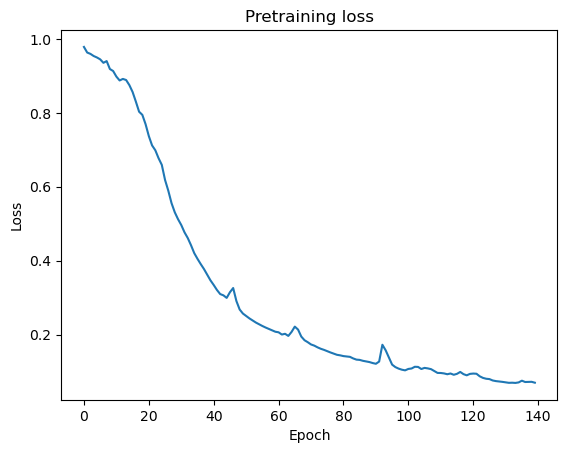

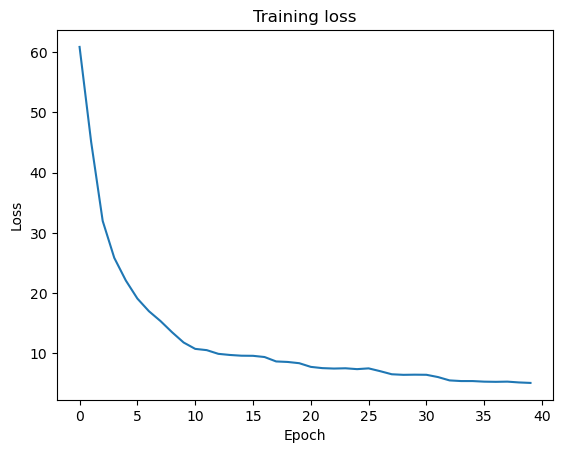

In [66]:
# plot losses
plt.plot(losses_pre)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Pretraining loss')
plt.show()

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training loss')
plt.show()

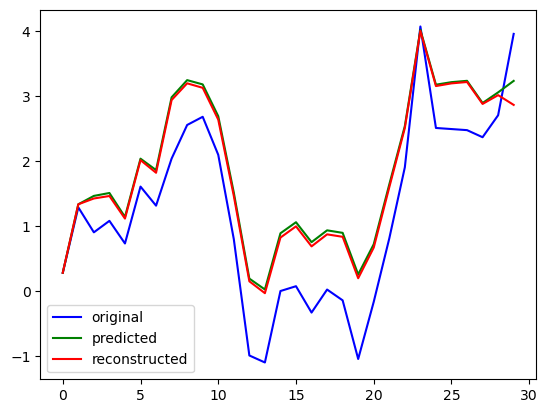

In [71]:
# pretrain the RNN model and test it
test_pretrain = True
if test_pretrain:
    # losses_pre = tsgm.pretrain_RNN(train_loader, n_epoch_pretrain=100, lrate=1e-4)
    i = np.random.randint(0, X_train.shape[0]-seq_len)
    j = np.random.randint(0, X_train.shape[1])
    seq_len = 30
    a = X_train[i:i+seq_len, :]

    memory = tsgm.RNN.encoder(a.unsqueeze(0)).squeeze(0)
    b = tsgm.RNN.predict(a[:1], memory.unsqueeze(0)).squeeze(0)
    
    c = tsgm.RNN(a.unsqueeze(0)).squeeze(0)

    a = a.detach().cpu().numpy()
    b = b.detach().cpu().numpy()
    c = c.detach().cpu().numpy()

    a_cum = np.cumsum(a, axis=0)
    b_cum = np.cumsum(b, axis=0)
    c_cum = np.cumsum(c, axis=0)

    plt.plot(a_cum[:,j], label='original', color='blue')
    plt.plot(b_cum[:,j], label='predicted', color='green')
    plt.plot(c_cum[:,j], label='reconstructed', color='red')
    plt.legend()
    plt.show()

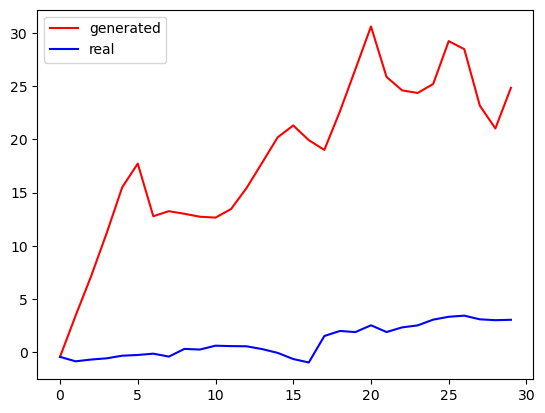

In [68]:
# take a random start
sample_size = 1
seq_len = 30
start_indices = np.random.randint(0, X_train.shape[0], sample_size)
start = X_train[start_indices, :]
gen_samples = tsgm.sample(start, sample_size, seq_len, dim_model)

i = 0
a = gen_samples[i, :, 0].cpu().detach().numpy()
b = X_train[start_indices[i]:start_indices[i]+seq_len, 0].cpu().detach().numpy()
a_cum = np.cumsum(a)
b_cum = np.cumsum(b)
plt.plot(a_cum, color = 'r', label = 'generated')
plt.plot(b_cum, color = 'b', label = 'real')
plt.legend()
plt.show()

In [69]:
# evaluation
from evaluation_metrics import TransformerModel
from evaluation_metrics import evaluate_synthetic_data

n_samples = 100
seq_len = 30

samples_orig = torch.zeros((n_samples, seq_len, n_feat))
for i in range(n_samples):
    idx = np.random.randint(0, X_train.shape[0]-seq_len)
    samples_orig[i] = X_train[idx:idx+seq_len]

start = samples_orig[:, 0, :]
gen_samples = tsgm.sample(start, n_samples, seq_len, dim_model)

samples_orig = samples_orig.cpu().detach().numpy()
gen_samples = gen_samples.cpu().detach().numpy()

# save_dir = 'Results/TSGM/Model/'
# gen_samples = np.load(os.path.join(save_dir, 'samples.npy'))

eval_model_d = TransformerModel(gen_samples.shape[2], 2, 32, 2, 0.1, task='classification')
eval_model_p = TransformerModel(gen_samples.shape[2], 2, 32, 2, 0.1, task='regression')
eval_results = evaluate_synthetic_data(eval_model_d, eval_model_p, gen_samples, samples_orig, train_ratio=0.8)
print(eval_results)

# save samples
# save_dir = 'Results/TSGM/Model/'
# np.save(os.path.join(save_dir, 'samples.npy'), gen_samples)

c:\Users\khale\anaconda3\Lib\site-packages\torch\nn\modules\transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Training LDS model...
Epoch [1/10], Loss: 0.11626709811389446
Epoch [2/10], Loss: 0.10558916069567204
Epoch [3/10], Loss: 0.09901360236108303
Epoch [4/10], Loss: 0.0930990744382143
Epoch [5/10], Loss: 0.08559110946953297
Epoch [6/10], Loss: 0.08024923410266638
Epoch [7/10], Loss: 0.07206026185303926
Epoch [8/10], Loss: 0.06527293939143419
Epoch [9/10], Loss: 0.05597838293761015
Epoch [10/10], Loss: 0.052373833023011684
Training LPS model...
Epoch [1/20], Loss: 4.066054344177246
Epoch [2/20], Loss: 4.161910533905029
Epoch [3/20], Loss: 3.9434509873390198
Epoch [4/20], Loss: 3.8684767484664917
Epoch [5/20], Loss: 3.795131504535675
Epoch [6/20], Loss: 3.798679828643799
Epoch [7/20], Loss: 3.755074381828308
Epoch [8/20], Loss: 3.624601721763611
Epoch [9/20], Loss: 3.537890672683716
Epoch [10/20], Loss: 3.5478001832962036
Epoch [11/20], Loss: 3.4577659368515015
Epoch [12/20], Loss: 3.52776175737381
Epoch [13/20], Loss: 3.566863715648651
Epoch [14/20], Loss: 3.453800857067108
Epoch [15/20], 

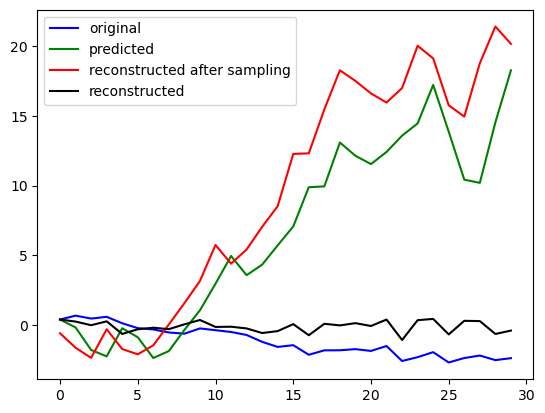

In [73]:
i = np.random.randint(0, n_samples)
feat = np.random.randint(0, n_feat)
a = samples_orig[i]
b, h =tsgm.sample(torch.from_numpy(a[0].reshape(1, 53)), 1, 30, dim_model, return_h=True)
c = tsgm.RNN.decoder(torch.from_numpy(a.reshape(1, 30, 53)), h)
d = tsgm.RNN(torch.from_numpy(a.reshape(1, 30, 53)))

b = b.squeeze(0).detach().cpu().numpy()
c = c.squeeze(0).detach().cpu().numpy()
d = d.squeeze(0).detach().cpu().numpy()

a_cum = np.cumsum(a, axis=0)
b_cum = np.cumsum(b, axis=0)
c_cum = np.cumsum(c, axis=0)

plt.plot(a_cum[:,feat], label='original', color='blue')
plt.plot(b_cum[:,feat], label='predicted', color='green')
plt.plot(c_cum[:,feat], label='reconstructed after sampling', color='red')
plt.plot(d[:,feat], label='reconstructed', color='black')
plt.legend()
plt.show()


#### Visualisations

In [ ]:
df_orig = df_orig['Ret'].unstack().T

In [ ]:
synth_data = gen_samples.reshape(-1, gen_samples.shape[2]).shape

In [25]:
synth_data = pd.DataFrame(gen_samples[0,:,:].detach().numpy(), index=df_orig[start_year_test:].index[:input_size], columns=df_orig.columns)

In [26]:
from plot_results import plot_data

In [28]:
columns = df_orig.columns.tolist()
starting_point = df_orig[:end_year].cumsum().dropna().iloc[-1]
plot_data(df_orig, synth_data, starting_point, columns[:10])

In [29]:
from evaluation_metrics import kl_divergence_columns, kl_divergence_rows, wasserstein_distance_columns, wasserstein_distance_rows, compute_frobenius_norm, compute_condition_number, compute_spectral_norm

In [30]:
true_data = df_orig[start_year_test:]

In [31]:
kl_col = kl_divergence_columns(synth_data,true_data)
kl_rows = kl_divergence_rows(synth_data,true_data)
wasserstein_col = wasserstein_distance_columns(synth_data,true_data)
wasserstein_rows = wasserstein_distance_rows(synth_data,true_data)


In [32]:
kl_col.mean().values[0]

2.462685184622529

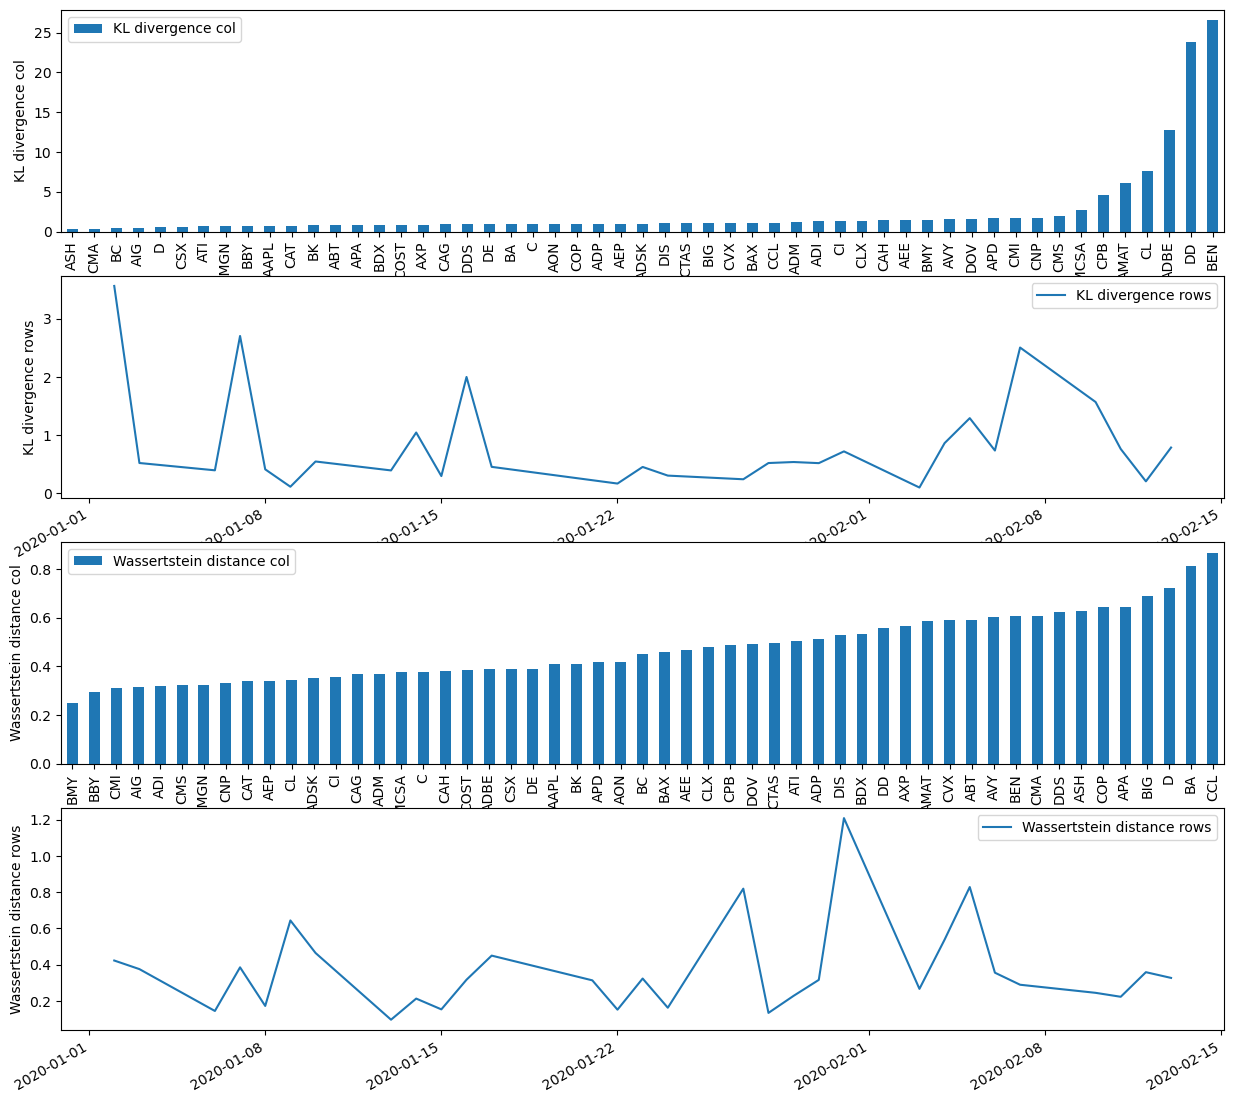

In [33]:

fig,axes = plt.subplots(nrows=4,ncols = 1,figsize = (15,15))
metrics = [kl_col,kl_rows,wasserstein_col, wasserstein_rows]
for i,ax in enumerate(axes):
    to_plot = metrics[i]
    title = to_plot.columns.tolist()[0]
    to_plot = to_plot.sort_values(by = title)
    if 'rows' in title:
        to_plot.plot(ax = axes[i],kind ='line')
    else :
        to_plot.plot(ax = axes[i],kind ='bar')
    axes[i].set_ylabel(title)


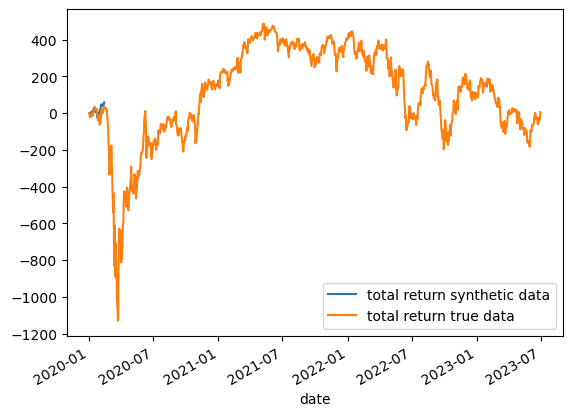

In [34]:
synth_data.cumsum().sum(1).plot(label = 'total return synthetic data')
true_data.cumsum().sum(1).plot(label = 'total return true data')
plt.legend()

In [35]:
cov_matrix_true = np.cov(true_data, rowvar=False)
cov_matrix_synthetic = np.cov(synth_data, rowvar=False)


# Calculate metrics
frobenius_norm = compute_frobenius_norm(cov_matrix_true, cov_matrix_synthetic)
spectral_norm = compute_spectral_norm(cov_matrix_true, cov_matrix_synthetic)
condition_number_true = compute_condition_number(cov_matrix_true)
condition_number_synthetic = compute_condition_number(cov_matrix_synthetic)

# Print metrics
print(f"Frobenius Norm: {frobenius_norm}")
print(f"Spectral Norm: {spectral_norm}")
print(f"Condition Number - True Data: {condition_number_true}")
print(f"Condition Number - Synthetic Data: {condition_number_synthetic}")



Frobenius Norm: 30.055142045592618
Spectral Norm: 28.78984362014638
Condition Number - True Data: 383.2139665503994
Condition Number - Synthetic Data: 1.411853179363414e+18


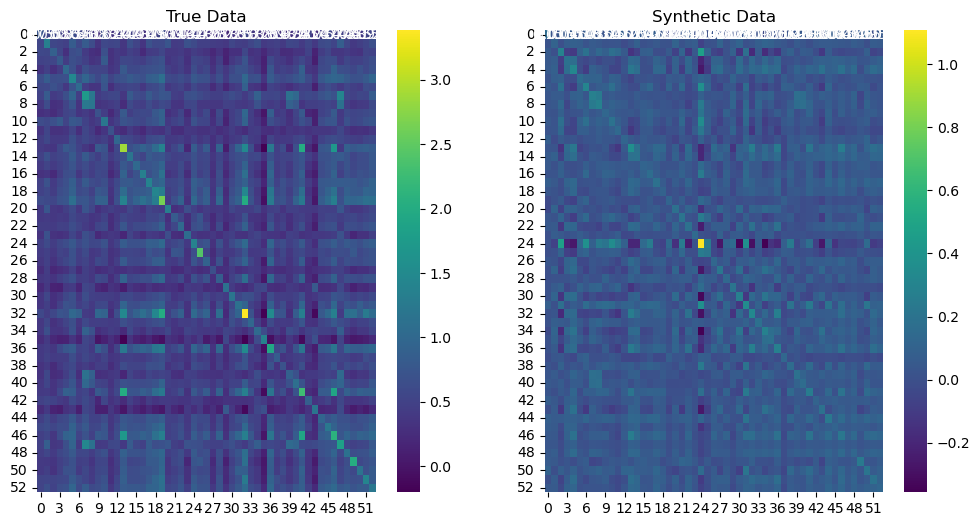

In [36]:
from plot_results import plot_covariance_matrices, plot_eigenvalues
# Plot covariance matrices
plot_covariance_matrices(cov_matrix_true, cov_matrix_synthetic)


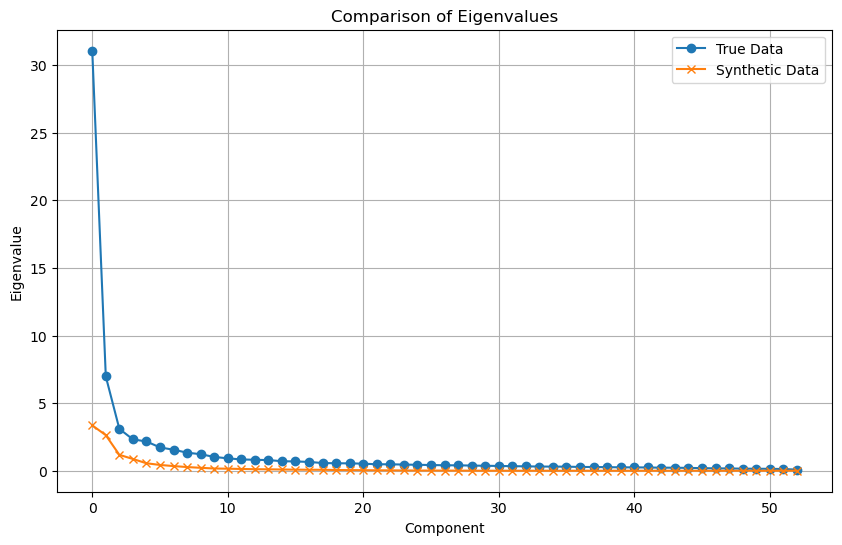

In [37]:
from evaluation_metrics import eigen_decomposition
from plot_results import plot_eigenvalues
# Eigenvalue decomposition
eigenvalues_true, eigenvectors_true = eigen_decomposition(cov_matrix_true)
eigenvalues_synthetic, eigenvectors_synthetic = eigen_decomposition(cov_matrix_synthetic)

# Plot eigenvalues
plot_eigenvalues(eigenvalues_true, eigenvalues_synthetic)


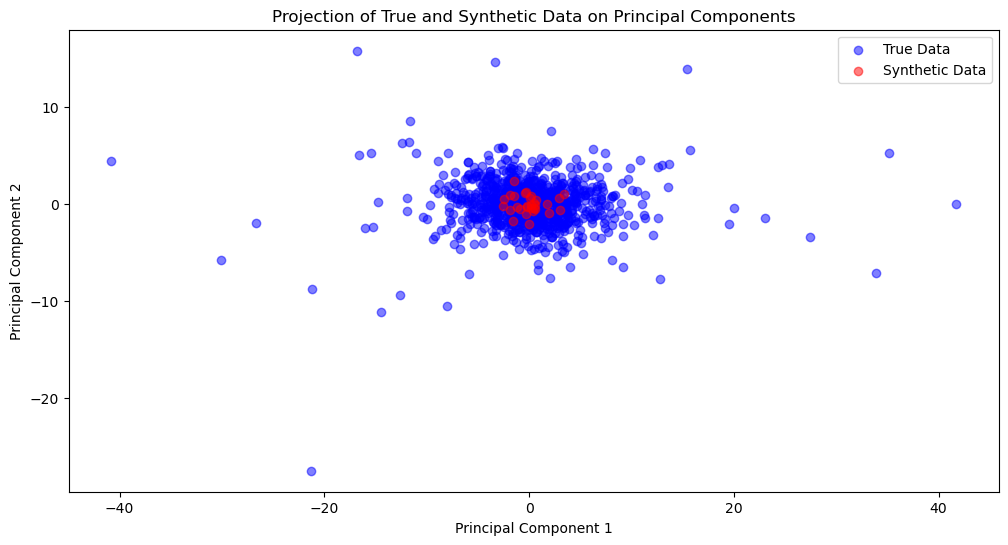

In [38]:
from evaluation_metrics import compute_principal_components, project_onto_principal_components
from plot_results import plot_projection_on_principal_components


# Compute principal components from true data
_, eigenvectors_true = compute_principal_components(true_data)

# Project both true and synthetic data onto these principal components
projection_true = project_onto_principal_components(true_data, eigenvectors_true)
projection_synthetic = project_onto_principal_components(synth_data, eigenvectors_true)

# Visualize the projections
plot_projection_on_principal_components(projection_true, projection_synthetic)


## DDPM

In [34]:
ddpm = DDPM(model = model, 
            optimizer = optim,
            device = device, 
            timesteps = timesteps, 
            beta1 = beta1, 
            beta2 = beta2, 
            n_epoch = n_epoch, 
            batch_size = batch_size, 
            lrate = lrate, 
            save_dir = save_dir)

In [ ]:
losses, maes, wasserstein_distances =ddpm.train(train_loader=train_loader)

In [ ]:
# Convert lists to DataFrame
metrics_df = pd.DataFrame({
    'Loss': losses,
    'MAE': maes,
    'Wasserstein Distance': wasserstein_distances
})

# Plot metrics
metrics_df.plot(subplots=True)
plt.xlabel('steps')
plt.show()

In [ ]:
n_sample = X_train.shape[0] // input_size

In [ ]:
gen_samples, _  = ddpm.sample(n_sample = n_sample, window_size = input_size, dim_input = n_feat, save_rate=20)

In [ ]:
"""tabddpm = ImputerDiffusion(
    model_qolmat, epochs=n_epoch, batch_size=batch_size, x_valid=df_reindexed, print_valid=True,index_datetime='date',
      freq_str = '1B',columnwise=False)"""
#tabddpm.fit(df_reindexed)
#pd.DataFrame(tabddpm.model.summary).plot(subplots=True)
#plt.xlabel('epochs')

### Evaluation

In [174]:
import json
from evaluation_metrics import TransformerModel
from evaluation_metrics import evaluate_synthetic_data
#path_results = os.getcwd() + "\\results\\DDPM\\"
path_results = os.getcwd() + "\\100\\"
parameters = [d for d in os.listdir(path_results) if os.path.isdir(os.path.join(path_results, d))]
print(parameters)
for param in parameters:
    print(param)
    path_parameters = path_results + param
    var = [d for d in os.listdir(path_parameters) if os.path.isdir(os.path.join(path_parameters, d))]
    print(var)
    train_ratio = 0.8
    results = {}
    for v in var:
        print(v)
        config_results = json.load(open(path_parameters + "\\" + v + '\\config.json', 'r'))
        #create  samples from df_orig time series
        seq_len = config_results["SEQ_LEN"]
        n_samples = X_train.shape[0] // seq_len
        samples_orig = np.zeros((n_samples, seq_len, n_feat))
        for i in range(n_samples):
            idx = np.random.randint(0, df_orig.shape[0]-seq_len)
            samples_orig[i] = df_orig.iloc[idx:idx+seq_len].values

        gen_samples = np.load(path_parameters + "\\" + v + '\\samples.npy')[:n_samples]
        eval_model_d = TransformerModel(gen_samples.shape[2], 2, 32, 2, 0.1, task='classification')
        eval_model_p = TransformerModel(gen_samples.shape[2], 2, 32, 2, 0.1, task='regression')
        eval_results = evaluate_synthetic_data(eval_model_d, eval_model_p, gen_samples, samples_orig, train_ratio=train_ratio)
        results[v] = eval_results    
    results_df = pd.DataFrame(results).T
    results_df.index = results_df.index.astype(float)
    results_df = results_df.sort_index()
    results_df.index.name = param
    results_df.plot(subplots=True, figsize=(10, 8), linewidth=2, marker='o')
    plt.xticks(results_df.index)
    plt.savefig('.\\plots\\' + param + '_epoch_300_timesteps_100'+'.png')

[]


#### Visualisations

In [95]:
df_orig = df_orig['Ret'].unstack().T

In [96]:
synth_data = gen_samples.reshape(-1, gen_samples.shape[2]).shape

In [98]:
synth_data = pd.DataFrame(gen_samples[0,:,:].detach().numpy(), index=df_orig[start_year_test:].index[:input_size], columns=df_orig.columns)

In [99]:
from plot_results import plot_data

In [100]:
columns = df_orig.columns.tolist()
starting_point = df_orig[:end_year].cumsum().dropna().iloc[-1]
plot_data(df_orig, synth_data, starting_point, columns[:10])

In [101]:
from evaluation_metrics import kl_divergence_columns, kl_divergence_rows, wasserstein_distance_columns, wasserstein_distance_rows, compute_frobenius_norm, compute_condition_number, compute_spectral_norm

In [102]:
true_data = df_orig[start_year_test:]

In [103]:
kl_col = kl_divergence_columns(synth_data,true_data)
kl_rows = kl_divergence_rows(synth_data,true_data)
wasserstein_col = wasserstein_distance_columns(synth_data,true_data)
wasserstein_rows = wasserstein_distance_rows(synth_data,true_data)


In [104]:
kl_col.mean().values[0]

5.200691360910532

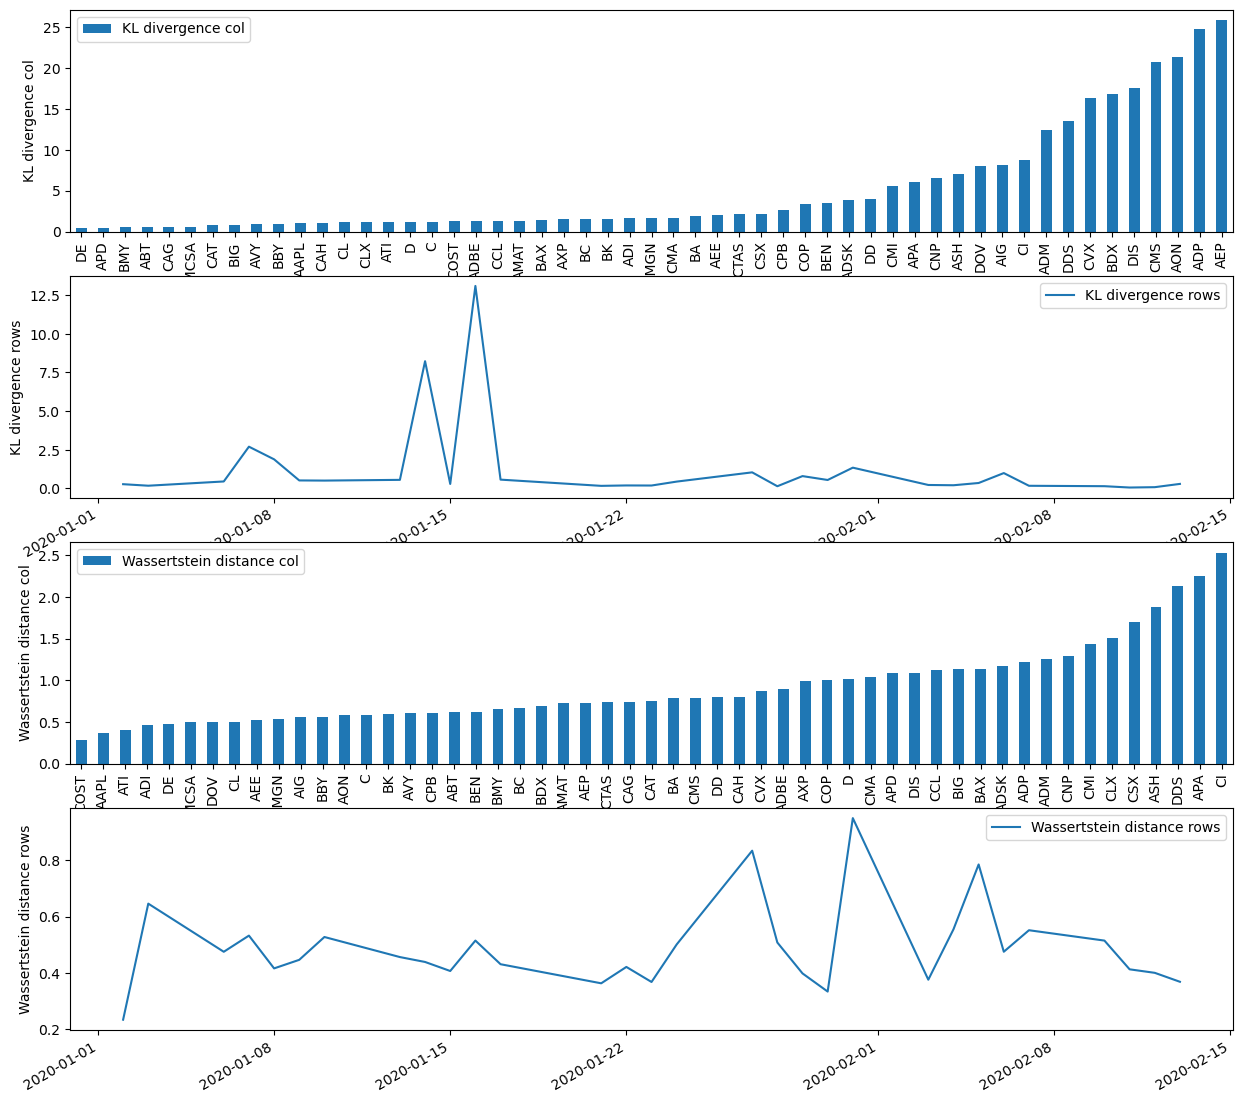

In [105]:

fig,axes = plt.subplots(nrows=4,ncols = 1,figsize = (15,15))
metrics = [kl_col,kl_rows,wasserstein_col, wasserstein_rows]
for i,ax in enumerate(axes):
    to_plot = metrics[i]
    title = to_plot.columns.tolist()[0]
    to_plot = to_plot.sort_values(by = title)
    if 'rows' in title:
        to_plot.plot(ax = axes[i],kind ='line')
    else :
        to_plot.plot(ax = axes[i],kind ='bar')
    axes[i].set_ylabel(title)


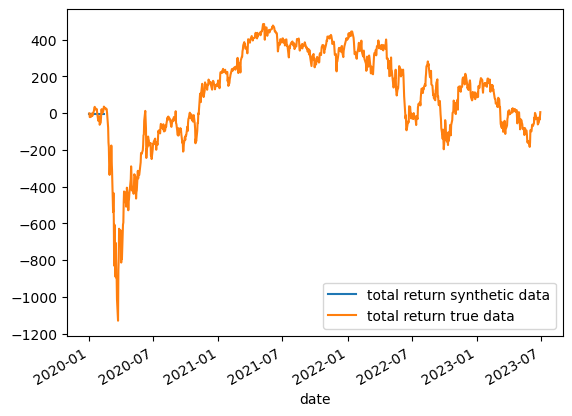

In [106]:
synth_data.cumsum().sum(1).plot(label = 'total return synthetic data')
true_data.cumsum().sum(1).plot(label = 'total return true data')
plt.legend()

In [108]:
cov_matrix_true = np.cov(true_data, rowvar=False)
cov_matrix_synthetic = np.cov(synth_data, rowvar=False)


# Calculate metrics
frobenius_norm = compute_frobenius_norm(cov_matrix_true, cov_matrix_synthetic)
spectral_norm = compute_spectral_norm(cov_matrix_true, cov_matrix_synthetic)
condition_number_true = compute_condition_number(cov_matrix_true)
condition_number_synthetic = compute_condition_number(cov_matrix_synthetic)

# Print metrics
print(f"Frobenius Norm: {frobenius_norm}")
print(f"Spectral Norm: {spectral_norm}")
print(f"Condition Number - True Data: {condition_number_true}")
print(f"Condition Number - Synthetic Data: {condition_number_synthetic}")



Frobenius Norm: 32.559734089017454
Spectral Norm: 31.053636008241302
Condition Number - True Data: 383.2139665503994
Condition Number - Synthetic Data: 1.0633268944163506e+18


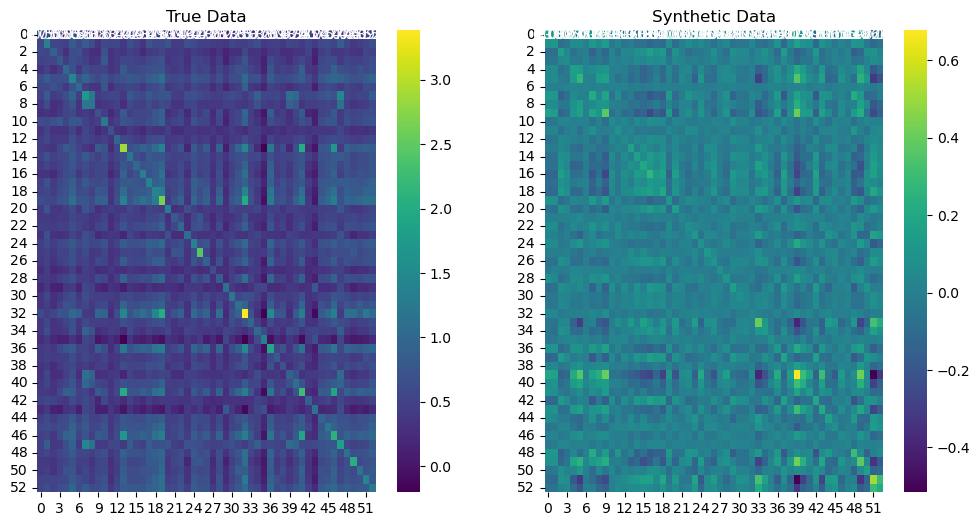

In [109]:
from plot_results import plot_covariance_matrices, plot_eigenvalues
# Plot covariance matrices
plot_covariance_matrices(cov_matrix_true, cov_matrix_synthetic)


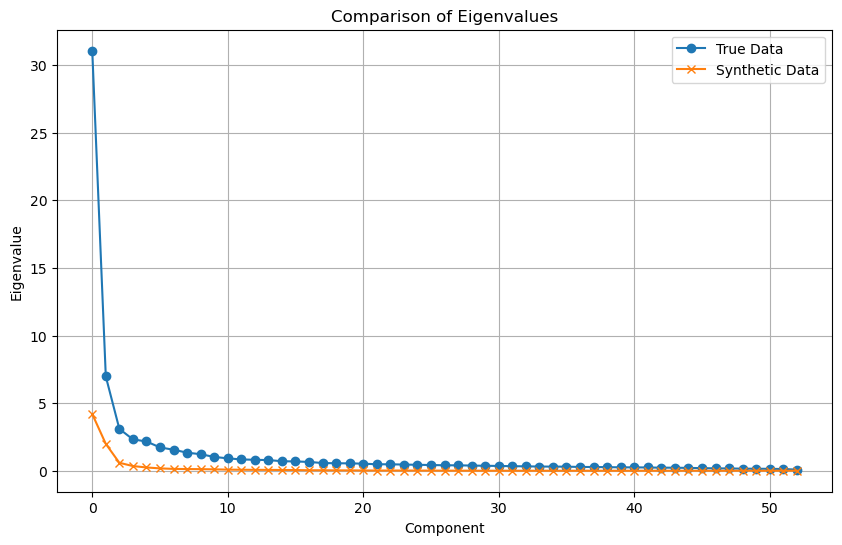

In [110]:
from evaluation_metrics import eigen_decomposition
from plot_results import plot_eigenvalues
# Eigenvalue decomposition
eigenvalues_true, eigenvectors_true = eigen_decomposition(cov_matrix_true)
eigenvalues_synthetic, eigenvectors_synthetic = eigen_decomposition(cov_matrix_synthetic)

# Plot eigenvalues
plot_eigenvalues(eigenvalues_true, eigenvalues_synthetic)


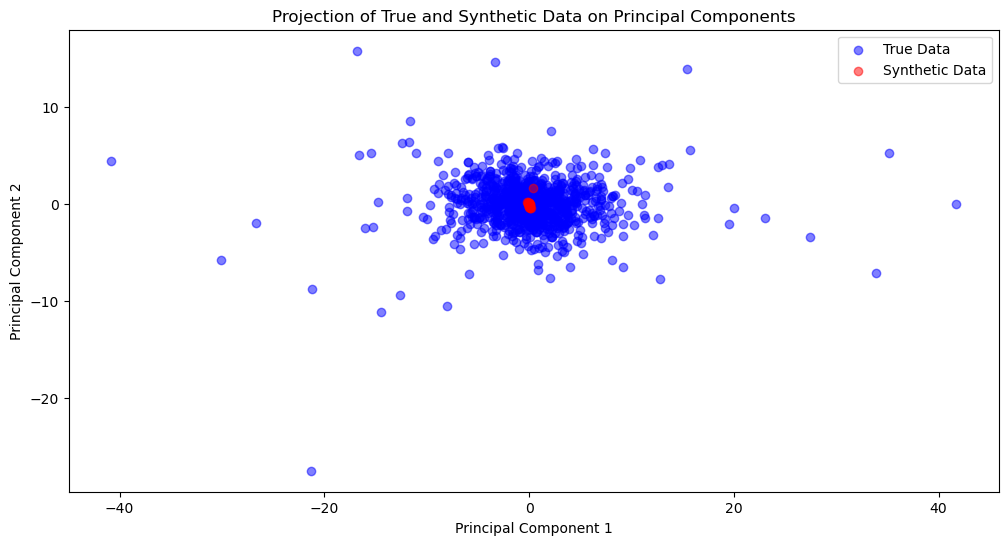

In [111]:
from evaluation_metrics import compute_principal_components, project_onto_principal_components
from plot_results import plot_projection_on_principal_components


# Compute principal components from true data
_, eigenvectors_true = compute_principal_components(true_data)

# Project both true and synthetic data onto these principal components
projection_true = project_onto_principal_components(true_data, eigenvectors_true)
projection_synthetic = project_onto_principal_components(synth_data, eigenvectors_true)

# Visualize the projections
plot_projection_on_principal_components(projection_true, projection_synthetic)
